In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from local_explanations import *
import utils
import models

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np

import torch
import torch_geometric.transforms as T
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split

from collections import defaultdict

%load_ext autoreload
%autoreload 2

In [3]:
import plotly.graph_objects as go


z = np.zeros((4,4))
for i , r1 in enumerate([9e-4, 9e-2, 0.9, 2]):
    for j , r2 in enumerate([9e-4, 9e-2, 0.9, 2]):
        with open(f'../logs/model_focal_num_proto_6_r1_{r1}_r2_{r2}_Mutagenicity.pkl', 'rb') as handle:
            uno = pickle.load(handle)
            z[i,j] = uno.val_metrics[uno.early_stopping.best_epoch]["acc_overall"]
        
sh_0, sh_1 = z.shape
x, y = [9e-4, 9e-2, 0.9, 2] , [9e-4, 9e-2, 0.9, 2]

In [14]:
layout = go.Layout(
    scene=dict(xaxis = dict(
                    tickmode = 'array',
                    tickvals = [],
                    type='category',
                    title="λ2"
                ),
               yaxis = dict(
                    tickmode = 'array',
                    tickvals = [],
                    type='category',
                    title="λ1"
                ),
               zaxis = dict(
                    title="LEN fidelity",
                   range=[0.5, 1],
                   dtick=0.1
                )
              )
)
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)], layout=layout)
fig.update_layout(autosize=False, width=500, height=500, coloraxis_showscale=False)
fig.show()
#fig.write_image("hyper_surface_mutag.pdf")

### read data

In [3]:
DATASET_NAME = "BAMultiShapes"

In [4]:
adjs_train , \
edge_weights_train , \
ori_classes_train , \
belonging_train , \
summary_predictions_train , \
le_classes_train = read_bamultishapes(evaluate_method=True, 
                                       remove_mix=False, 
                                       min_num_include=5, 
                                       split="TRAIN") #, manual_cut=0.47377795

print(len(adjs_train) , len(edge_weights_train), len(ori_classes_train) , len(belonging_train))
print(np.unique(summary_predictions_train["wrong"], return_counts=True) , np.unique(summary_predictions_train["correct"], return_counts=True))
print(np.unique(le_classes_train, return_counts=True))

Num shapes: 909, Num Preserved: 901, Ratio: 0.991, Num Multipleshapes: 240
num_class_relationship_broken:  7  num_multi_shapes_removed: 0
912 912 754 912
(array([1, 5, 7]), array([ 6,  3, 37], dtype=int64)) (array([0, 1, 2, 3, 4, 5, 6]), array([ 34,  36,  45, 242, 124, 136, 137], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6]), array([117, 153, 151, 251,  73,  97,  70], dtype=int64))


In [5]:
print(np.unique(summary_predictions_train["wrong"], return_counts=True))
print(np.unique(summary_predictions_train["correct"], return_counts=True))

(array([1, 5, 7]), array([ 6,  3, 37], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 34,  36,  45, 242, 124, 136, 137], dtype=int64))


In [6]:
sum([6,  3, 37, 34, 36,  45, 242, 124, 136, 137])

800

In [7]:
34 / 40

0.85

In [8]:
bamultishapes2_classes_names[1] , bamultishapes2_classes_names[5] , bamultishapes2_classes_names[7]

('grid', 'house+wheel', 'all')

In [9]:
bamultishapes2_classes_names

['house',
 'grid',
 'wheel',
 'ba',
 'house+grid',
 'house+wheel',
 'wheel+grid',
 'all']

In [5]:
adjs_val , \
edge_weights_val , \
ori_classes_val , \
belonging_val , \
summary_predictions_val , \
le_classes_val = read_bamultishapes(evaluate_method=True, 
                                     remove_mix=False, 
                                     min_num_include=5, 
                                     split="VAL") #, manual_cut=0.47377795

print(len(adjs_val) , len(edge_weights_val), len(ori_classes_val) , len(belonging_val))
print(np.unique(summary_predictions_val["wrong"], return_counts=True) , np.unique(summary_predictions_val["correct"], return_counts=True))
print(np.unique(le_classes_val, return_counts=True))

Num shapes: 113, Num Preserved: 113, Ratio: 1.0, Num Multipleshapes: 38
num_class_relationship_broken:  0  num_multi_shapes_removed: 0
106 106 94 106
(array([1, 7]), array([2, 4], dtype=int64)) (array([0, 1, 2, 3, 4, 5, 6]), array([ 2,  4,  7, 31, 10, 20, 20], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 9, 11, 17, 31,  8, 15, 15], dtype=int64))


In [6]:
adjs_test , \
edge_weights_test , \
ori_classes_test , \
belonging_test , \
summary_predictions_test , \
le_classes_test = read_bamultishapes(evaluate_method=True, 
                                      remove_mix=False, 
                                      min_num_include=5, 
                                      split="TEST") #, manual_cut=0.47377795

print(len(adjs_test) , len(edge_weights_test), len(ori_classes_test) , len(belonging_test))
print(np.unique(summary_predictions_test["wrong"], return_counts=True) , np.unique(summary_predictions_test["correct"], return_counts=True))
print(np.unique(le_classes_test, return_counts=True))

Num shapes: 118, Num Preserved: 117, Ratio: 0.992, Num Multipleshapes: 31
num_class_relationship_broken:  1  num_multi_shapes_removed: 0
119 119 99 119
(array([1]), array([1], dtype=int64)) (array([0, 1, 2, 3, 4, 5, 6]), array([ 7,  4,  7, 31, 17, 14, 19], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6]), array([17, 20, 18, 33,  9, 11, 11], dtype=int64))


### dataset

C:\Users\Steve\Desktop\GNN\gnn_logic_global_expl\code\utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_attr=torch.tensor(t.weight).reshape(-1, 1),


(array([0, 1, 2, 3, 4, 5, 6]), array([117, 153, 151, 251,  73,  97,  70], dtype=int64))
(tensor([0, 1]), tensor([365, 547]))


('house+wheel', 11, tensor([11]))

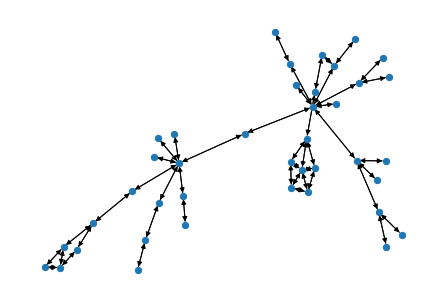

In [7]:
device = "cpu" #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = T.Compose([
    T.NormalizeFeatures(),
])     


dataset_train = utils.LocalExplanationsDataset("", adjs_train, edge_weights_train, "same", transform=transform, y=le_classes_train, belonging=belonging_train, task_y=ori_classes_train)
dataset_val = utils.LocalExplanationsDataset("", adjs_val, edge_weights_val, "same", transform=transform, y=le_classes_val, belonging=belonging_val, task_y=ori_classes_val)
dataset_test = utils.LocalExplanationsDataset("", adjs_test, edge_weights_test, "same", transform=transform, y=le_classes_test, belonging=belonging_test, task_y=ori_classes_test)


##
# debug Dataset
##
print(np.unique(le_classes_train, return_counts=True))
print(torch.unique(dataset_train.data.task_y, return_counts=True))
idx = 18
nx.draw(to_networkx(dataset_train[idx]), node_size=40)   # debug Dataset
bamultishapes_classes_names[dataset_train[idx].y] , belonging_train[idx] , dataset_train[idx].graph_id

### Run the model

In [91]:
batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging_train))
train_group_loader = DataLoader(dataset_train, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_val))
val_group_loader = DataLoader(dataset_val, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_test))
test_group_loader = DataLoader(dataset_test, batch_sampler=batch_sampler)


torch.manual_seed(42)
hyper = {
    "len_lr": 0.0005,
    "proto_lr": 0.001,
    "le_emb_lr": 0.001,
    "coeff_divloss": 0.000,
    "coeff_pdist": 0.,
    "coeff_gae": 0.,
    "coeff_r1": 0.09,
    "coeff_r2": 0.00099,
    "coeff_ce": 0.0,
    "coeff_de": 0.,
    "coeff_logic_loss": 0.00,
    "focal_gamma": 2, #3
    "focal_alpha": -1,
    "ts": 1,
    "te": 1,
    "focal_loss": True,
    "debug_prototypes": False,
    "num_prototypes": 6,
    "dim_prototypes": 10,
    "num_le_features": 5,
    "embedder_backbone": "GIN",
    "embedder_num_layers": 2,
    "activation": "leaky",
    "assign_func": "straight_sim",
    "LEN_temperature": 1,
    "remove_attention": True,
    "log_images": True,
    "log_models": False,
    "num_epochs": 2000
}

len_model    = models.LEN(hyper["num_prototypes"], 
                          hyper["LEN_temperature"], 
                          remove_attention=hyper["remove_attention"]).to(device)
le_model     = models.LEEmbedder(num_features=hyper["num_le_features"], 
                                 activation=hyper["activation"], 
                                 num_hidden=hyper["dim_prototypes"]).to(device)
expl         = models.GlobalExplainer(len_model, 
                               le_model, 
                               train_group_loader, 
                               val_group_loader, 
                               device, 
                               hyper_params=hyper,
                               classes_names=bamultishapes_classes_names,
                               dataset_name=DATASET_NAME).to(device)

prefix = "DEBUG" if hyper["debug_prototypes"] else ""
suffix = "no attn" if hyper["remove_attention"] else ""
expl.iterate(num_epochs=hyper["num_epochs"], log_wandb=False, name_wandb=f"MShapes2 {hyper['num_prototypes']}prots {prefix} {suffix}")

(array([0., 1., 2., 3., 4., 5., 6.], dtype=float32), array([117, 153, 151, 251,  73,  97,  70], dtype=int64))
[0.991108   0.00653978]


KeyboardInterrupt: 

In [ ]:
expl.inspect_embedding(train_group_loader)

In [26]:
expl.train_metrics[565]

{'loss': 0.00966600887477398,
 'acc_per_class': 0.9787798408488063,
 'acc_overall': tensor(0.9788),
 'len_loss': 0.009369286708533764,
 'logic_loss': 0.0,
 'prototype_distance_loss': 0.0,
 'r1_loss:': 0.0002458486123941839,
 'r2_loss:': 5.0874008593382314e-05,
 'div_loss:': 0.0,
 'debug_loss:': 0.0,
 'concept_entropy_loss:': 0.0,
 'distribution_entropy_loss:': 0.0,
 'temperature': 1.0,
 'cluster_acc_mean': 0.8328355432109981,
 'cluster_acc_std': 0.20824889865505317,
 'concept_vector_entropy': tensor(0., grad_fn=<MeanBackward0>),
 'prototype_assignements': <wandb.sdk.data_types.Histogram at 0x1fa331d5888>,
 'concept_vector': <wandb.sdk.data_types.Histogram at 0x1fa331d5608>}

(array([0., 1., 2., 3., 4., 5., 6.], dtype=float32), array([17, 20, 18, 33,  9, 11, 11], dtype=int64))


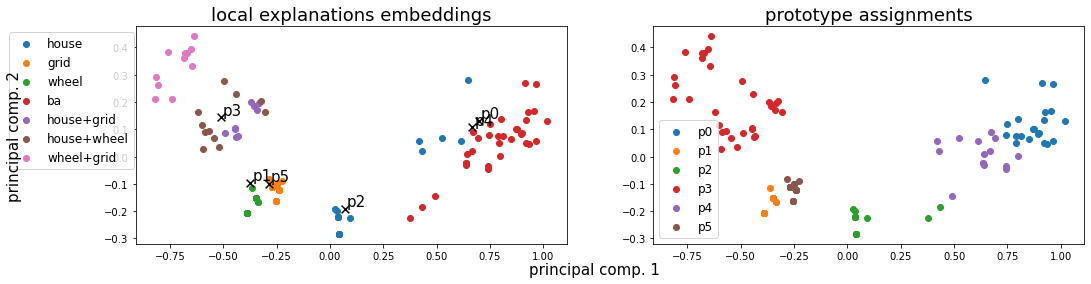

Alpha norms:
tensor([[0.2903, 0.2963, 0.2931, 1.0000, 0.1765, 0.3043],
        [0.0354, 0.1237, 0.0900, 1.0000, 0.0234, 0.0861]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.816283 +- 0.226387
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([21, 18, 14, 31, 15, 20], dtype=int64))
Logic formulas:
For class 0:
0.98989898989899 (feature001) | (feature002) | (feature000) | ((feature004) | ((feature004 & feature002) | (feature005)
For class 1:
0.98989898989899 (feature003) | (feature005 & feature002) | (feature005 & feature001) | (feature002 & feature001)
Accuracy as classifier:  0.9899
LEN fidelity:  tensor(0.9899)



In [10]:
hyper = {
    "len_lr": 0.0005,
    "proto_lr": 0.001,
    "le_emb_lr": 0.001,
    "coeff_divloss": 0.000,
    "coeff_pdist": 0.,
    "coeff_gae": 0.,
    "coeff_r1": 0.09,
    "coeff_r2": 0.00099,
    "coeff_ce": 0.0,
    "coeff_de": 0.,
    "coeff_logic_loss": 0.00,
    "focal_gamma": 2, #3
    "focal_alpha": -1,
    "ts": 1,
    "te": 1,
    "focal_loss": True,
    "debug_prototypes": False,
    "num_prototypes": 6,
    "dim_prototypes": 10,
    "num_le_features": 5,
    "embedder_backbone": "GIN",
    "embedder_num_layers": 2,
    "activation": "leaky",
    "assign_func": "straight_sim",
    "LEN_temperature": 1,
    "remove_attention": True,
    "log_images": True,
    "log_models": False,
    "num_epochs": 2000
}
batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging_train))
train_group_loader = DataLoader(dataset_train, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_val))
val_group_loader = DataLoader(dataset_val, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_test))
test_group_loader = DataLoader(dataset_test, batch_sampler=batch_sampler)

len_model2    = models.LEN(hyper["num_prototypes"], 
                          hyper["LEN_temperature"], 
                          remove_attention=hyper["remove_attention"]).to(device)
le_model2     = models.LEEmbedder(num_features=hyper["num_le_features"], 
                                 activation=hyper["activation"], 
                                 num_hidden=hyper["dim_prototypes"]).to(device)
best_expl         = models.GlobalExplainer(len_model2, 
                               le_model2, 
                               train_group_loader, 
                               val_group_loader, 
                               device, 
                               hyper_params=hyper,
                               classes_names=bamultishapes_classes_names,
                               dataset_name=DATASET_NAME).to(device)
best_expl.load_state_dict(torch.load("../trained_models/BAMultiShapes.pt"))
best_expl.eval()

best_expl.inspect_embedding(test_group_loader)

### materialize prototypes

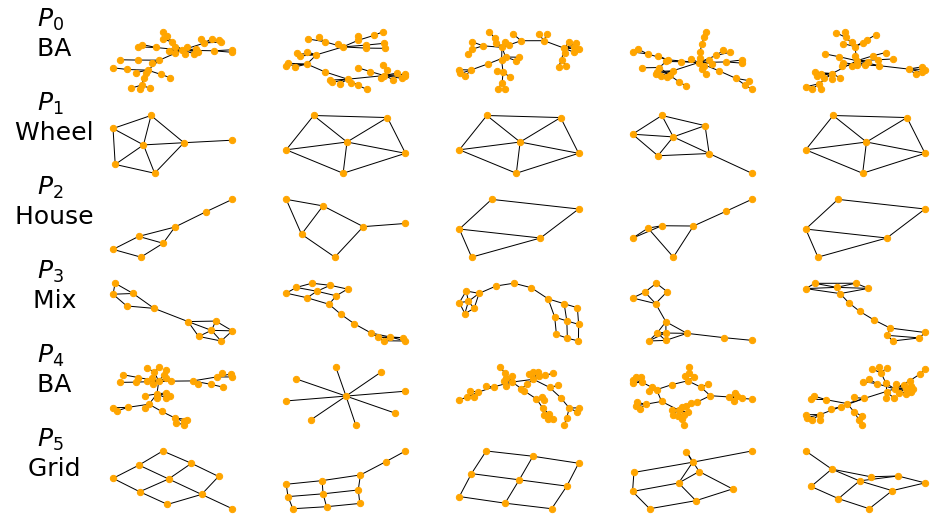

In [22]:
best_expl.eval()
x_train , emb , concepts_assignement , y_train_1h , le_classes , le_idxs , belonging = best_expl.get_concept_vector(test_group_loader, 
                                                                                                                    return_raw=True)        
proto_names = {
    0: "BA",
    1: "Wheel",
    2: "House",
    3: "Mix",
    4: "BA",
    5: "Grid",
}
torch.manual_seed(42)
fig = plt.figure(figsize=(15,5*1.8))
n = 0
for p in range(best_expl.hyper["num_prototypes"]):
    idxs = le_idxs[concepts_assignement.argmax(-1) == p]
    idxs = idxs[torch.randperm(len(idxs))]    
    for ex in range(5):
        n += 1
        ax = plt.subplot(best_expl.hyper["num_prototypes"],5,n)      
        G = to_networkx(dataset_test[int(idxs[ex])], to_undirected=True)
        pos = nx.spring_layout(G, seed=42)
        nx.draw(G, pos, node_size=40, ax=ax, node_color="orange")
        ax.axis("on")
        plt.box(False)
        
for p in range(best_expl.hyper["num_prototypes"]):
    plt.subplot(best_expl.hyper["num_prototypes"],5,5*p + 1)
    plt.ylabel(f"$P_{p}$\n {proto_names[p]}", size=25, rotation="horizontal", labelpad=50)

plt.savefig("prototypes_bamultishapes.pdf")
plt.show() 

# MUTAG

In [3]:
DATASET_NAME = "Mutag"

In [4]:
adjs_train , \
edge_weights_train , \
ori_adjs_train , \
ori_classes_train , \
belonging_train , \
summary_predictions_train , \
le_classes_train ,\
embeddings_train = read_mutagenicity(evaluate_method=False, 
                                     manual_cut=0.37731856, #0.42392886
                                     split="TRAIN")

print(np.unique(le_classes_train, return_counts=True))

belonging_train2 = np.array(belonging_train)
le_classes_train = np.array(le_classes_train)
c = 0
for b in np.unique(belonging_train):
    if ori_classes_train[b] == 1 and 0 in le_classes_train[belonging_train2 == b]:
        c += 1
print("Samples of class 1 containing NO2: ", c/len(ori_classes_train))
c = 0
for b in np.unique(belonging_train):
    if ori_classes_train[b] == 0 and 0 not in le_classes_train[belonging_train2 == b]:
        c += 1
print("Samples of class 0 not containing NO2: ", c/len(ori_classes_train))

print(len(adjs_train) , len(edge_weights_train), len(ori_adjs_train) , len(ori_classes_train) , len(belonging_train))
np.unique(summary_predictions_train["wrong"], return_counts=True) , np.unique(summary_predictions_train["correct"], return_counts=True)

This is a NH2 local explanation
(array([0, 1]), array([619, 400], dtype=int64))
Samples of class 1 containing NO2:  0.04709141274238227
Samples of class 0 not containing NO2:  0.12188365650969529
1019 1019 722 722 1019


((array([0, 1]), array([ 88, 346], dtype=int64)),
 (array([0, 1]), array([1833, 1202], dtype=int64)))

In [5]:
adjs_val , \
edge_weights_val , \
ori_adjs_val , \
ori_classes_val , \
belonging_val , \
summary_predictions_val , \
le_classes_val ,\
embeddings_val = read_mutagenicity(evaluate_method=False, 
                                   manual_cut=0.37731856,
                                   split="VAL")

print(np.unique(le_classes_val, return_counts=True))

belonging_val2 = np.array(belonging_val)
le_classes_val = np.array(le_classes_val)
c = 0
for b in np.unique(belonging_val):
    if ori_classes_val[b] == 1 and 0 in le_classes_val[belonging_val2 == b]:
        c += 1
print("Samples of class 1 containing NO2: ", c/len(ori_classes_val))
c = 0
for b in np.unique(belonging_val):
    if ori_classes_val[b] == 0 and 0 not in le_classes_val[belonging_val2 == b]:
        c += 1
print("Samples of class 0 not containing NO2: ", c/len(ori_classes_val))

print(len(adjs_val) , len(edge_weights_val), len(ori_adjs_val) , len(ori_classes_val) , len(belonging_val))
np.unique(summary_predictions_val["wrong"], return_counts=True) , np.unique(summary_predictions_val["correct"], return_counts=True)

(array([0, 1]), array([88, 50], dtype=int64))
Samples of class 1 containing NO2:  0.02127659574468085
Samples of class 0 not containing NO2:  0.11702127659574468
138 138 94 94 138


((array([0, 1]), array([ 8, 49], dtype=int64)),
 (array([0, 1]), array([237, 140], dtype=int64)))

In [6]:
adjs_test , \
edge_weights_test , \
ori_adjs_test , \
ori_classes_test , \
belonging_test , \
summary_predictions_test , \
le_classes_test ,\
embeddings_test = read_mutagenicity(evaluate_method=False, 
                                   manual_cut=0.37731856,
                                   split="TEST")

print(np.unique(le_classes_test, return_counts=True))

belonging_test2 = np.array(belonging_test)
le_classes_test = np.array(le_classes_test)
c = 0
for b in np.unique(belonging_test):
    if ori_classes_test[b] == 1 and 0 in le_classes_test[belonging_test2 == b]:
        c += 1
print("Samples of class 1 containing NO2: ", c/len(ori_classes_test))
c = 0
for b in np.unique(belonging_test):
    if ori_classes_test[b] == 0 and 0 not in le_classes_test[belonging_test2 == b]:
        c += 1
print("Samples of class 0 not containing NO2: ", c/len(ori_classes_test))

print(len(adjs_test) , len(edge_weights_test), len(ori_adjs_test) , len(ori_classes_test) , len(belonging_test))
np.unique(summary_predictions_test["wrong"], return_counts=True) , np.unique(summary_predictions_test["correct"], return_counts=True)

(array([0, 1]), array([65, 54], dtype=int64))
Samples of class 1 containing NO2:  0.011904761904761904
Samples of class 0 not containing NO2:  0.14285714285714285
119 119 84 84 119


((array([0, 1]), array([ 6, 54], dtype=int64)),
 (array([0, 1]), array([229, 145], dtype=int64)))

C:\Users\Steve\Desktop\GNN\gnn_logic_global_expl\code\utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_attr=torch.tensor(t.weight).reshape(-1, 1),


(array([0, 1]), array([619, 400], dtype=int64))
(tensor([0, 1]), tensor([748, 271]))


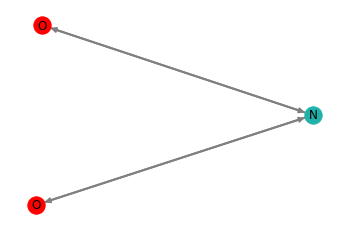

(15, tensor([15]))

In [7]:
device = "cpu" #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = None  

dataset_train = utils.LocalExplanationsDataset("", adjs_train, edge_weights_test, "embeddings", transform=transform, y=le_classes_train, belonging=belonging_train, task_y=ori_classes_train, precomputed_embeddings=embeddings_train)
dataset_val = utils.LocalExplanationsDataset("", adjs_val, edge_weights_val, "embeddings", transform=transform, y=le_classes_val, belonging=belonging_val, task_y=ori_classes_val, precomputed_embeddings=embeddings_val)
dataset_test = utils.LocalExplanationsDataset("", adjs_test, edge_weights_test, "embeddings", transform=transform, y=le_classes_test, belonging=belonging_test, task_y=ori_classes_test, precomputed_embeddings=embeddings_test)


##
# debug Dataset
##
print(np.unique(le_classes_train, return_counts=True))
print(torch.unique(dataset_train.data.task_y, return_counts=True))
idx = 18
utils.plot_molecule(dataset_train[idx])
belonging_train[idx] , dataset_train[idx].graph_id

In [9]:
batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging_train))
train_group_loader = DataLoader(dataset_train, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_val))
val_group_loader = DataLoader(dataset_val, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_test))
test_group_loader = DataLoader(dataset_test, batch_sampler=batch_sampler)


torch.manual_seed(42)
hyper = {
    "len_lr": 0.0005,
    "proto_lr": 0.001,
    "le_emb_lr": 0.001,
    "coeff_divloss": 0.000,
    "coeff_pdist": 0.,
    "coeff_gae": 0.,
    "coeff_r1": 0.09,
    "coeff_r2": 0.00099,
    "coeff_ce": 0.0,
    "coeff_de": 0.,
    "coeff_logic_loss": 0.00,
    "focal_gamma": 2, #3
    "focal_alpha": -1,
    "ts": 1,
    "te": 1,
    "focal_loss": True,
    "debug_prototypes": False,
    "num_prototypes": 2,
    "dim_prototypes": 10,
    "num_le_features": 14,
    "embedder_backbone": "GIN",
    "embedder_num_layers": 2,
    "activation": "leaky",
    "assign_func": "straight_sim",
    "LEN_temperature": 1,
    "remove_attention": True,
    "log_images": True,
    "log_models": True,
    "num_epochs": 500
}

len_model    = models.LEN(hyper["num_prototypes"], 
                          hyper["LEN_temperature"], 
                          remove_attention=hyper["remove_attention"]).to(device)
le_model     = models.LEEmbedder(num_features=hyper["num_le_features"], 
                                 activation=hyper["activation"], 
                                 num_hidden=hyper["dim_prototypes"]).to(device)
expl         = models.GlobalExplainer(len_model, 
                               le_model, 
                               train_group_loader, 
                               val_group_loader, 
                               device, 
                               hyper_params=hyper,
                               classes_names=mutag_classes_names,
                               dataset_name=DATASET_NAME).to(device)

prefix = "DEBUG" if hyper["debug_prototypes"] else ""
suffix = "no attn" if hyper["remove_attention"] else ""
expl.iterate(num_epochs=hyper["num_epochs"], log_wandb=False, name_wandb=f"MUTAG {hyper['num_prototypes']}prots {prefix} {suffix}")

(array([0., 1.], dtype=float32), array([619, 400], dtype=int64))
[0.8408194  0.10297436]


KeyboardInterrupt: 

(array([0., 1.], dtype=float32), array([65, 54], dtype=int64))
[0.585498   0.39227337]


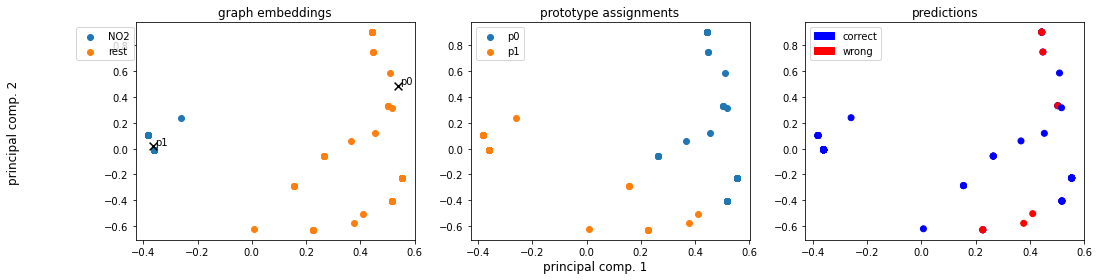

Alpha norms:
tensor([[0.9689, 1.0000],
        [1.0000, 0.4144]], grad_fn=<DivBackward0>)
Concept Purity: 0.933333 +- 0.066667
Concept distribution:  (array([0, 1], dtype=int64), array([44, 75], dtype=int64))
Logic formulas:
For class 0:
0.8571428571428571 (feature001) | ((feature000 & feature001)
For class 1:
0.8571428571428571 (feature000)
Accuracy as classifier:  0.8571
LEN fidelity:  tensor(0.8571)



In [39]:
expl.inspect_embedding(test_group_loader)

(array([0., 1.], dtype=float32), array([65, 54], dtype=int64))
[0.585498   0.39227343]


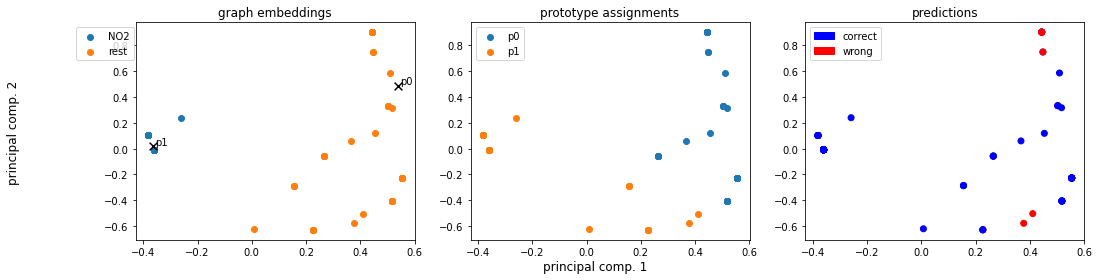

Alpha norms:
tensor([[0.9689, 1.0000],
        [1.0000, 0.4144]], grad_fn=<DivBackward0>)
Concept Purity: 0.933333 +- 0.066667
Concept distribution:  (array([0, 1], dtype=int64), array([44, 75], dtype=int64))
Logic formulas:
For class 0:
0.8571428571428571 (feature001) | ((feature000 & feature001)
For class 1:
0.8571428571428571 (feature000)
Accuracy as classifier:  0.8571
LEN fidelity:  tensor(0.8571)



In [11]:
len_model2    = models.LEN(hyper["num_prototypes"], 
                          hyper["LEN_temperature"], 
                          remove_attention=hyper["remove_attention"]).to(device)
le_model2     = models.LEEmbedder(num_features=hyper["num_le_features"], 
                                 activation=hyper["activation"], 
                                 num_hidden=hyper["dim_prototypes"]).to(device)
best_expl_mutag         = models.GlobalExplainer(len_model2, 
                               le_model2, 
                               train_group_loader, 
                               val_group_loader, 
                               device, 
                               hyper_params=hyper,
                               classes_names=mutag_classes_names,
                               dataset_name=DATASET_NAME).to(device)
best_expl_mutag.load_state_dict(torch.load("../trained_models/Mutagenicity.pt"))
best_expl_mutag.eval()

best_expl_mutag.inspect_embedding(test_group_loader)

### materialize prototypes

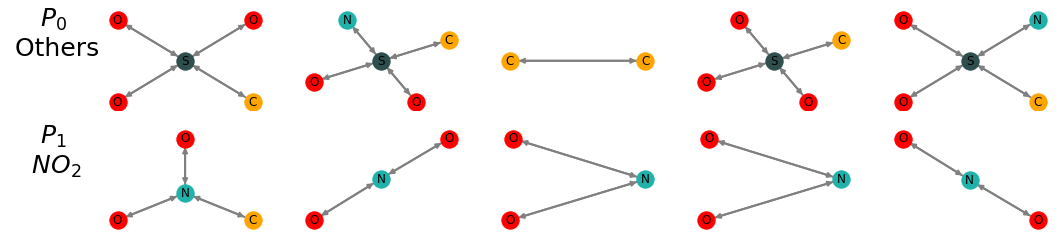

In [143]:
best_expl_mutag.eval()
x_train , emb , concepts_assignement , y_train_1h , le_classes , le_idxs , belonging = best_expl_mutag.get_concept_vector(train_group_loader, 
                                                                                                               return_raw=True)        
proto_names = {
    0: "Others",
    1: "$NO_2$",
}
torch.manual_seed(42)
fig = plt.figure(figsize=(17,4))
n = 0
for p in range(best_expl_mutag.hyper["num_prototypes"]):
    idxs = le_idxs[concepts_assignement.argmax(-1) == p]
    idxs = idxs[torch.randperm(len(idxs))]
    
    for ex in range(5):
        n += 1
        plt.subplot(best_expl_mutag.hyper["num_prototypes"],5,n)        
        #G = to_networkx(dataset_train[int(idx)])
        #nx.draw(G, node_size=50)
        utils.plot_molecule(dataset_train[int(idxs[ex])], composite_plot=True)

for p in range(expl.hyper["num_prototypes"]):
    plt.subplot(expl.hyper["num_prototypes"],5,5*p + 1)
    plt.ylabel(f"$P_{p}$\n {proto_names[p]}", size=25, rotation="horizontal", labelpad=50)
plt.savefig("prototypes_mutagenicity.pdf")
plt.show() 